<a href="https://colab.research.google.com/github/jemalmgr/AH2179/blob/main/Hand_In_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AH2179 Hand-In Assignment 1
## Use regression models to predict bus arrival delays
By Jennifer Malmgren

### Data preparation

In [28]:
# Load and view dataset

import pandas as pd

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)

df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [29]:
# Check more detailed information about the dataset

print(df.shape, end='\n\n')
df.info()

(2179, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


In [30]:
# Remove unwanted columns

df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)
df.head(10)

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,39,-4,28.641509
1,168,0,39,181,27.880597
2,231,0,39,244,27.852941
3,150,17,39,143,27.826087
4,965,35,51,947,42.029412
5,33,19,46,30,38.970588
6,75,26,46,63,38.840580
7,58,15,46,52,34.059701
8,904,35,46,888,34.102941
9,141,12,46,140,34.000000


<Axes: xlabel='Recurrent_delay', ylabel='Count'>

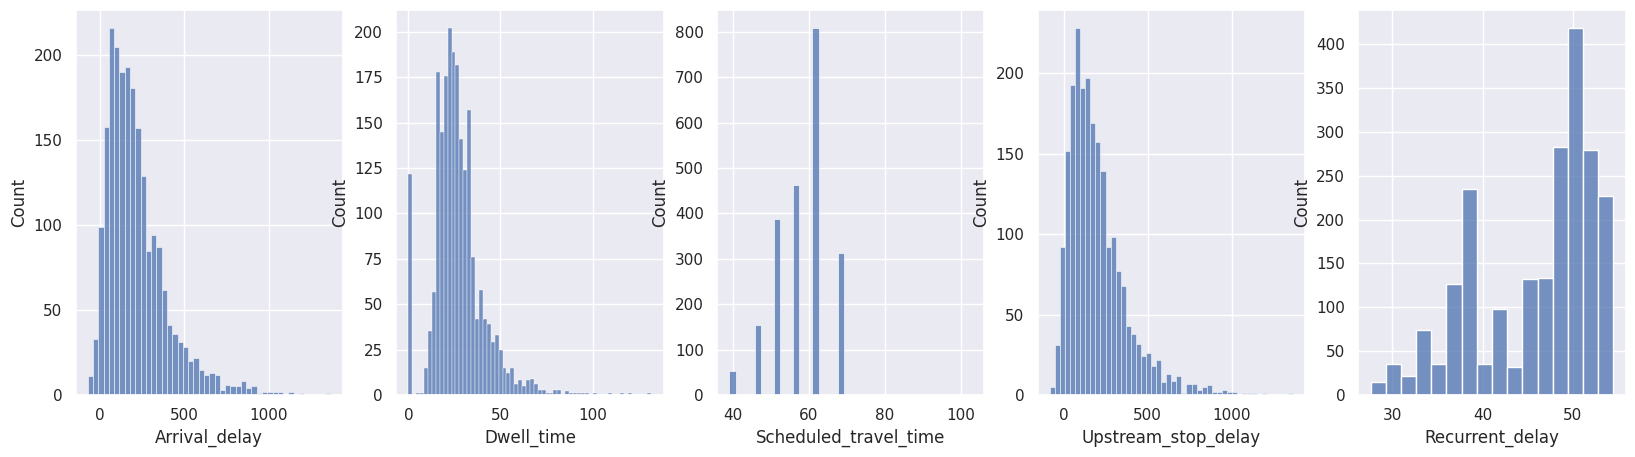

In [31]:
# Check the distribution of the data

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

sns.histplot(x=df['Arrival_delay'], ax=axs[0])
sns.histplot(x=df['Dwell_time'], ax=axs[1])
sns.histplot(x=df['Scheduled_travel_time'], ax=axs[2])
sns.histplot(x=df['Upstream_stop_delay'], ax=axs[3])
sns.histplot(x=df['Recurrent_delay'], ax=axs[4])

In [32]:
# Remove outliers

import numpy as np
from scipy import stats

df_filtered = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

df_filtered.head(10)

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,39,-4,28.641509
1,168,0,39,181,27.880597
2,231,0,39,244,27.852941
3,150,17,39,143,27.826087
5,33,19,46,30,38.970588
6,75,26,46,63,38.840580
7,58,15,46,52,34.059701
9,141,12,46,140,34.000000
10,45,16,46,48,32.941176
11,66,0,46,83,32.855072


In [33]:
# Check influence of input variables

corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

,Arrival_delay
Arrival_delay,1.000000
Upstream_stop_delay,0.993935
Dwell_time,0.218745
Recurrent_delay,0.162692
Scheduled_travel_time,0.100695


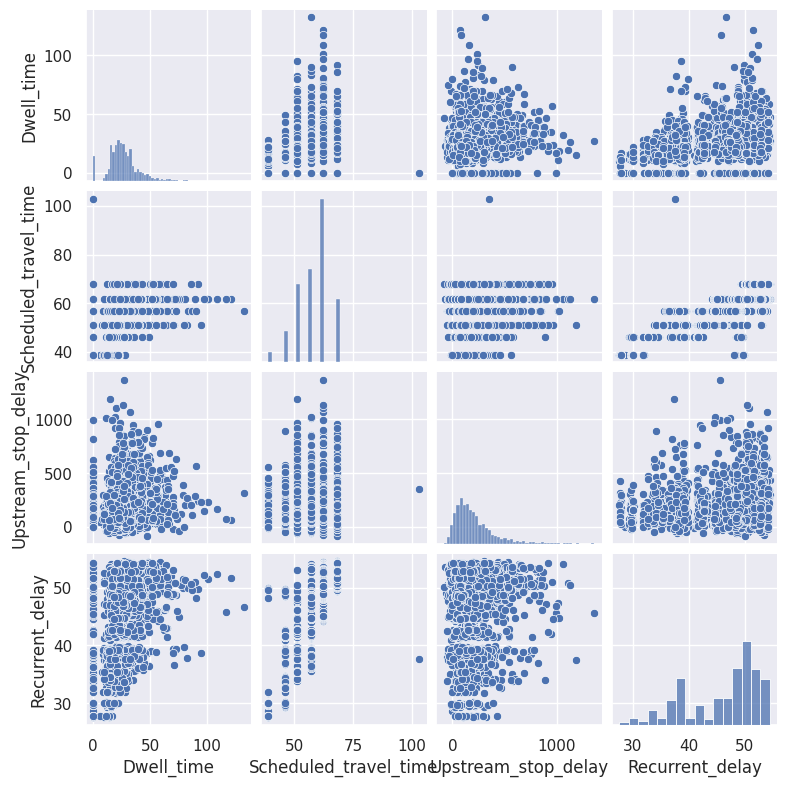

In [34]:
# Visually explore relationships

x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

sns.pairplot(x, height=2)

### Modeling with xGBoost

In [35]:
# Split data into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [36]:
# Hyperparameter tuning

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [50, 250, 500], # number of boosting rounds
    'eta': [x/100 for x in range(0,31,1)], # learning rate
    'gamma': [x/10.0 for x in range(0,105,5)], # minimum loss reduction required to split a node
    'max_depth': [x for x in range(11)], # maximum depth of a tree
    'min_child_weight': [x for x in range(11)], # minimum sum of weights of all observations required in a child
}

random_search = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=params, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 3.0, 'eta': 0.05}
Best Score: 0.9912252761458028


In [38]:
# Make and evaluate best model

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 10.766593700975452
Mean Squared Error: 214.1244412131951
R-squared: 0.9928194252901473


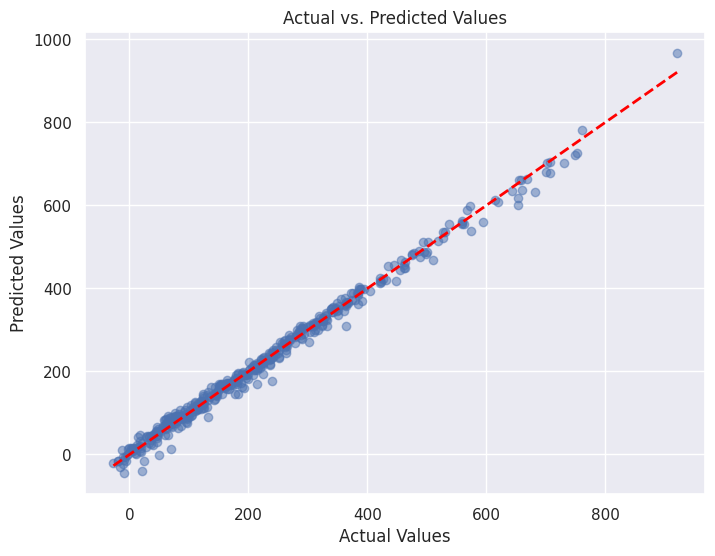

In [39]:
# Visualize results

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5) # Scatterplot of actual vs. predicted values
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2) # diagonal line for reference (perfect predictions)
plt.show()